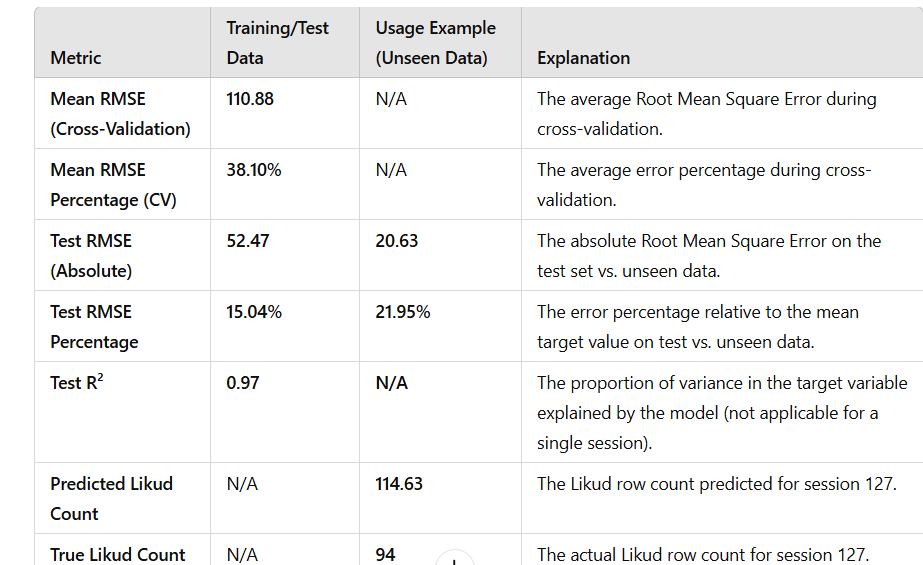

# Block 1: Train the Model and Generate Metrics

Model saved as 'linear_model.pkl'.


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dis

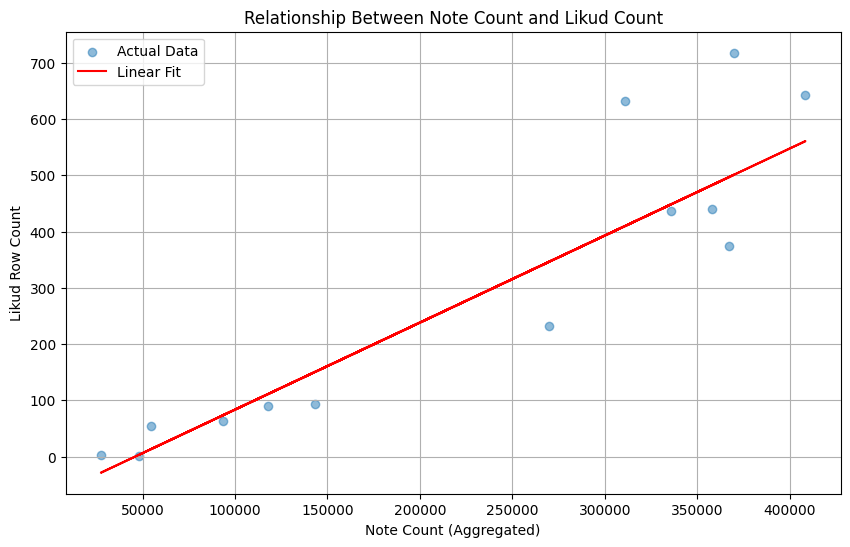

{'Mean RMSE (Cross-Validation)': '113.84', 'Mean RMSE Percentage (Cross-Validation)': '39.12%', 'Test RMSE (Absolute)': '125.94', 'Test RMSE Percentage': '43.38%', 'Test R²': '0.83'}


In [ ]:
import pandas as pd
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
dataset_path = 'processed_combined_data.csv'  # Replace with your dataset path
data = pd.read_csv(dataset_path)

# Feature engineering: Ensure 'note_count' is correctly defined
data['note_count'] = data['text'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)

# Calculate the number of rows for הליכוד in each session
likud_rows = data[data['party'] == 'הליכוד']
likud_counts = likud_rows.groupby('session').size().reset_index(name='count')

# Aggregate features for training: Total note_count for all parties in each session
session_features = data.groupby('session').agg({
    'note_count': 'sum'  # Total note count for the session
}).reset_index()

# Merge with the target variable (count of הליכוד rows)
training_features = session_features.merge(likud_counts, on='session', how='left')
training_features['count'] = training_features['count'].fillna(0).astype(int)

# Define features and target for training
X = training_features[['note_count']]  # Aggregated features
y = training_features['count']         # Number of הליכוד rows (target)

# Add stratification bins with fewer classes (3 bins instead of 5)
training_features['count_bin'] = pd.qcut(training_features['count'], q=3, labels=False)

# Train-test split with reduced bins
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=training_features['count_bin']
)


# Initialize and train the Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Save the trained model
with open('linear_model.pkl', 'wb') as file:
    pickle.dump(linear_model, file)
print("Model saved as 'linear_model.pkl'.")

# Cross-validation with Stratified K-Fold
strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_rmse_scores = []
for train_idx, test_idx in strat_kfold.split(X, training_features['count_bin']):
    X_cv_train, X_cv_test = X.iloc[train_idx], X.iloc[test_idx]
    y_cv_train, y_cv_test = y.iloc[train_idx], y.iloc[test_idx]

    # Train and validate the model
    linear_model.fit(X_cv_train, y_cv_train)
    y_cv_pred = linear_model.predict(X_cv_test)
    cv_rmse_scores.append(mean_squared_error(y_cv_test, y_cv_pred, squared=False))

# Evaluate the model on the test set
y_test_pred = linear_model.predict(X_test)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
r2_test = r2_score(y_test, y_test_pred)
mean_rmse_cv = np.mean(cv_rmse_scores)
mean_rmse_cv_percentage = (mean_rmse_cv / y.mean()) * 100
rmse_test_percentage = (rmse_test / y_test.mean()) * 100

# Plot relationship between note_count and count
plt.figure(figsize=(10, 6))
plt.scatter(X['note_count'], y, alpha=0.5, label='Actual Data')
plt.plot(X['note_count'], linear_model.predict(X), color='red', label='Linear Fit')
plt.title('Relationship Between Note Count and Likud Count')
plt.xlabel('Note Count (Aggregated)')
plt.ylabel('Likud Row Count')
plt.legend()
plt.grid()
plt.show()

# Display metrics
metrics = {
    "Mean RMSE (Cross-Validation)": f"{mean_rmse_cv:.2f}",
    "Mean RMSE Percentage (Cross-Validation)": f"{mean_rmse_cv_percentage:.2f}%",
    "Test RMSE (Absolute)": f"{rmse_test:.2f}",
    "Test RMSE Percentage": f"{rmse_test_percentage:.2f}%",
    "Test R²": f"{r2_test:.2f}"
}
print(metrics)


#Block 2: Testing Unseen Data Using run_model


In [ ]:
def run_model(file_name, true_counts_file=None):
    """
    Predict the number of Likud rows in each session based on unseen data from other parties.
    Also calculates RMSE and R² if true counts are provided.

    Args:
        file_name (str): Path to the unseen dataset CSV file.
        true_counts_file (str): Optional path to a file containing true counts for evaluation.

    Returns:
        pd.DataFrame: Predicted number of Likud rows per session, along with RMSE and R² metrics if true counts are provided.
    """
    # Load the unseen dataset
    unseen_data = pd.read_csv(file_name)

    # Preprocess unseen data to create `note_count`
    unseen_data['note_count'] = unseen_data['text'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)

    # Aggregate features for each session
    aggregated_features = unseen_data.groupby('session').agg({
        'note_count': 'sum',  # Total note count for the session
    }).reset_index()

    # Load the trained model
    with open('linear_model.pkl', 'rb') as file:
        model = pickle.load(file)

    # Predict using the loaded model
    aggregated_features['predicted_likud_count'] = model.predict(aggregated_features[['note_count']])

    # If true counts are provided, calculate metrics
    if true_counts_file:
        # Load the true counts dataset
        true_data = pd.read_csv(true_counts_file)

        # Create the `count` column for the true counts file (number of Likud rows per session)
        likud_rows = true_data[true_data['party'] == 'הליכוד']
        true_counts = likud_rows.groupby('session').size().reset_index(name='count')

        # Merge true counts with predictions
        results = aggregated_features.merge(true_counts, on='session', how='left')
        results['true_likud_count'] = results['count'].fillna(0).astype(int)

        # Calculate RMSE and R²
        rmse = mean_squared_error(results['true_likud_count'], results['predicted_likud_count'], squared=False)
        r2 = r2_score(results['true_likud_count'], results['predicted_likud_count'])
        rmse_percentage = (rmse / results['true_likud_count'].mean()) * 100

        # Display metrics
        metrics = {
            "RMSE (Absolute)": f"{rmse:.2f}",
            "RMSE Percentage": f"{rmse_percentage:.2f}%",
            "R²": f"{r2:.2f}"
        }
        print(metrics)

        return results[['session', 'predicted_likud_count', 'true_likud_count']], metrics

    # Return predictions if no true counts are provided
    return aggregated_features[['session', 'predicted_likud_count']]


# RUN YOUR UNSEEN FILE/S HERE AND CALCULATE METRICS (NEEDS MORE THAN ONE UNSEEN SESSION OTHERWISE THE R2 WILL SHOW NAN BECAUSE IT NEEDS VARIANCE)

In [ ]:
unseen_dataset_path = 'session_127_no_likud.csv'  # Replace with actual file path
predictions = run_model(unseen_dataset_path)
print(predictions)


   session  predicted_likud_count
0      127             123.954699


In [ ]:
unseen_dataset_path = 'session_127_no_likud.csv'  # Replace with actual file path
true_counts_path = 'session_127.csv'  # Replace with actual file path
predictions, metrics = run_model(unseen_dataset_path, true_counts_file=true_counts_path)
print(predictions)
print(metrics)


{'RMSE (Absolute)': '29.95', 'RMSE Percentage': '31.87%', 'R²': 'nan'}
   session  predicted_likud_count  true_likud_count
0      127             123.954699                94
{'RMSE (Absolute)': '29.95', 'RMSE Percentage': '31.87%', 'R²': 'nan'}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
